<div class="alert alert-block alert-info" style="margin-top: 20px">

### Notebook takes around an hour to execute fully. 
    Intermediate results can be explored in the folder 'results'.
    
</div>

<div class="alert alert-block alert-success" style="margin-top: 20px">

## Table of contents
    
</div>

### 1. [Building Networkx Graphs](#1)
    1. Graph Utils
### 2. [Similarity Function](#2)
    1. IO Similarity
    2. II Similarity
    3. RUN Similarity
    4. LIB Similarity
### 3. [Topological Clustering](#3)
    1. Building Similarity List
    2. Modularization Algorithm
### 4. [Thorough Clustering](#4)
    1. Checking for Cyclic Merges
    2. Building Similarity Matrix
    3. Modularization Algorithm
### 5. [Experiments](#5)
    1. WEV Calculation
    2. Plotting WEV for Different Weights
    3. Plotting WEV for Different Static Metrics
    4. Comparing Clusterings

<div class="alert alert-block alert-warning" style="margin-top: 20px">

## Note
   
</div>

All functions up until the Experiments Section are also implemented in our main framework (see `graph_modularization.py`) but in this Notebook, users can explore different modularization parameters and visualize results with ease.

<div class="alert alert-block alert-success" id="1" style="margin-top: 20px">

## 1. Building Networkx Graphs
    
</div>

### Collecting Dictionaries

In [808]:
import json

In [809]:
def save_dictionaries(dictionaries, filename):
    with open(filename, 'w') as fp:
        json.dump(dictionaries, fp, indent=4)

In [810]:
def get_dictionaries_from_file(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

In [811]:
def display_dictionaries(dictionaries):
    for d in dictionaries:
        print(d)

***
### Core Networkx Functionality

In [812]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import pygraphviz as pgv

In [813]:
def build_nodes(relevantDictionaries, Graph):
    """ Add nodes to graph. Each node saves a dictionary it represents. """
    for d in relevantDictionaries:
        Graph.add_nodes_from([(d["id"], d)])

In [814]:
def add_label(edgeLabels, edge, data):
    """
    Adds shared data name to edge labels.
    """
    if edge in edgeLabels.keys():
        edgeLabels[edge] += ", " + data
    else:
        edgeLabels[edge] = data
    return edgeLabels

In [815]:
def find_edges(renamedDictionaries):
    """ Match inputs and outputs of renamed dictionaries to find edges."""
    edges = list()
    edgelabels = dict()
    for d in renamedDictionaries:
        # search for outgoing edges of operator
        for output in d["output"]:
            for d2 in renamedDictionaries:
                for input in d2["input"]:
                    # add edge if data is passed between two dictionaries
                    if output[0] == input[0]:
                        edge = (d["id"],d2["id"])
                        edges.append(edge)
                        edgelabels = add_label(edgelabels, edge, output[0])
                        break
    return edges, edgelabels

In [816]:
def add_labeled_edge(Graph, edge, edgelabels):
    label = edgelabels[edge]
    Graph.add_edges_from([edge], label=label)

In [817]:
def build_edges(renamedDictionaries, Graph):
    """ Adds edges to graph. """
    edges, edgelabels = find_edges(renamedDictionaries)
    #Graph.add_edges_from(edges)
    for edge in edges:
        add_labeled_edge(Graph, edge, edgelabels)

In [818]:
def build_graph(renamedDictionaries, Graph):
    """ Calls node and edge colleciton. """
    build_nodes(renamedDictionaries, Graph)
    build_edges(renamedDictionaries, Graph)

In [819]:
def display_graph(Graph, filename):
    """
    Saves Graph as dot image.
    """
    A = to_agraph(Graph)
    A.layout('dot')
    A.draw(filename)

***
### Preparing Graph

In [820]:
def get_successor_nodes(Graph, parentID):
    """
    Gets successor node dictionaries.
    """
    successorIDs = list(Graph.successors(parentID))
    successorNodes = [Graph.nodes[ID] for ID in successorIDs]
    return successorNodes

In [821]:
def get_node_inputs(nodes):
    """
    Returns list of all inputs from nodes.
    """
    inputs = list()
    for node in nodes:
        inputs += node["input"]
    return inputs

In [822]:
def is_file(name):
    """
    Check if constant value is file.
    """
    if isinstance(name, str):
        return name.endswith(('.csv', '.png', '.py', '.jpg', '.txt'))
    return False

In [823]:
def delete_unnecessary_outputs(Graph):
    """
    Deletes all node outputs that are not needed by another node, and that are not files.
    """
    for ID in Graph.nodes:
        successors = get_successor_nodes(Graph, ID)
        successorsInputs = get_node_inputs(successors)
        for output in Graph.nodes[ID]["output"]:
            if not output in successorsInputs:
                if not is_file(output[0]):
                    Graph.nodes[ID]["output"].remove(output)

***

## 1.1 Graph Utils

In [824]:
def sum_runtime(Graph):
    """
    Sum over execution time of all Graph nodes.
    """
    run = 0
    for ID in Graph.nodes:
        run += Graph.nodes[ID]["runtime"]
    return run

In [825]:
def sum_size(Graph):
    """
    Sum over output size of all Graph nodes in byte.
    """
    size = 0
    for ID in Graph.nodes:
        for output in Graph.nodes[ID]["output"]:
            size += output[2]
    return size

In [826]:
def to_child(Graph, a, b):
    """
    Reassigns a and b so that b is child of a or None is returned.
    """
    # a is child of b
    if a in list(Graph.successors(b)):
        return b, a
    
    # b is child of a
    if b in list(Graph.successors(a)):
        return a, b
    
    # neither is child of other
    return None, None

#### Node Update

In [827]:
# ! the type key will be ignored from here onwards for better readability of final nodes

In [828]:
def merge_nodes_real(a,b, needed_inputs, needed_outputs):
    """
    Returns new node containing information from two original nodes.
    """
    node = {"id":[], "type":"", "input":[], "output":[], "dependencies":[], "code":"", "runtime":0}
    
    node["id"] = a["id"]
    #node["type"] = a["type"] + ", " + b["type"]
    node["input"] = needed_inputs
    node["output"] = needed_outputs
    node["dependencies"] = list(set(a["dependencies"] + b["dependencies"]))
    node["code"] = a["code"] + "\n\n" + b["code"]
    node["runtime"] = a["runtime"] + b["runtime"]
    
    return node

In [829]:
def get_needed_outputs(Graph, a, b):
    """
    When Merging nodes (a,b), we only want to keep outputs that are still needed by other nodes.
    """
    still_needed_outputs = list()
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    a_succs = list(Graph.successors(a))
    a_other_children = [child for child in a_succs if child != b]
    b_succs = list(Graph.successors(b))
    b_other_children = [child for child in b_succs if child != a]
    
    # collect the inputs of children of a and b
    possible_outputs = list()
    for succ in a_other_children + b_other_children:
        nodeSucc = Graph.nodes[succ]
        for i in nodeSucc["input"]:
            possible_outputs.append(i)
    
    # check if a or b contribute to the inputs collected above
    # if yes: these outputs should not be discarded while merging (a,b)
    for o in possible_outputs:
        if o in nodeA["output"] or o in nodeB["output"]:
            if o not in still_needed_outputs:
                still_needed_outputs.append(o)
                
    return still_needed_outputs

In [830]:
def get_needed_inputs(Graph, a, b):
    """
    When Merging nodes (a,b), we want to discard inputs that are either output of a or b.
    """
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    needed_inputs = list()
    other_b_ins = [i for i in nodeB["input"] if i not in nodeA["output"]]
    other_a_ins = [i for i in nodeA["input"] if i not in nodeB["output"]]
    needed_inputs = other_b_ins
    for i in other_a_ins:
        if i not in needed_inputs:
            needed_inputs.append(i)
            
    return needed_inputs

#### Graph Update

In [831]:
def redirect_edges(Graph, a, b):
    """
    Merging node b into a: we have to redirect all in-/out-edges of b to a.
    """
    # redirect b ingoing edges
    preds = list(Graph.predecessors(b))
    for pred in preds:
        if pred != a:
            Graph.add_edge(pred,a)
        
    # redirect b outgoing edges
    outs = list(Graph.successors(b))
    for out in outs:
        if out != a:
            Graph.add_edge(a,out)

In [832]:
def update_graph(Graph, a, b, node):
    """
    Merge nodes a and b in Graph with node.
    """
    # replaces node a with merged node
    attrs = {a: node}
    nx.set_node_attributes(Graph, attrs)
    
    # redirects edges from b to a
    redirect_edges(Graph, a, b)
    
    # deletes b
    Graph.remove_node(b)
    
    return Graph

***

In [833]:
# Get merged dictionaries
def extract_dictionaries(Graph):
    dictionaries = list()
    for i in range(0, len(Graph.nodes)):
        node = list(Graph.nodes)[i]
        dictionaries.append(Graph.nodes[node])
    return dictionaries

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

##### Big Demo

In [834]:
dictionaries = get_dictionaries_from_file("pretty_renamed_dictionaries.json")

In [835]:
print("original number of nodes: ", len(dictionaries))

original number of nodes:  134


In [836]:
Graph = nx.DiGraph()
build_graph(dictionaries, Graph)
display_graph(Graph, "results/original_graph.png")

In [837]:
#delete_unnecessary_outputs(Graph)

In [838]:
maxRuntime = sum_runtime(Graph)
maxDatasize = sum_size(Graph)
print("Maximum Runtime: ", maxRuntime)
print("Maximum Serialization Size: ", maxDatasize)

Maximum Runtime:  42.1617329120636
Maximum Serialization Size:  7760733


***
### Testing Correctness of Dictionaries
*A dictionary is correct, if all inputs needed are either files or they are created as output by another dictionary.*

In [839]:
def check_correct_input(dictionaries):
    ins = list()
    outs = list()
    IDS = list()
    for d in dictionaries:
        for i in d["input"]:
            if not i in outs:
                print(">> ", d["id"])
                print(i)
                ins.append(i)
                IDS.append(d["id"])
        for o in d["output"]:
            outs.append(o)
    #return ins, IDS

In [840]:
check_correct_input(dictionaries)

>>  23
['data/train.csv', 'file', 63]
>>  27
['data/test.csv', 'file', 62]


<div class="alert alert-block alert-success" id="2" style="margin-top: 20px">

## 2. Similarity Function
    
</div>

### 2.1 IO Similarity

In [841]:
# IO Similarity
def get_IO_dependency(Graph, a, b):
    """
    Find size of shared data between nodes a and b.
    """
    datasize = 0
    
    # if a is not child of b or vice versa, they do not shared data
    a, b = to_child(Graph, a, b)
    if a is None:
        return 0
    
    # else determine IO size
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    for o in nodeA["output"]:
        for i in nodeB["input"]:
            if o == i:
                datasize += i[2]
    
    return datasize

In [842]:
def get_IO_similarity(Graph, a, b, maxDatasize, weight):
    """
    Return normalized, weighted IO similarity.
    """
    datasize = get_IO_dependency(Graph, a, b)  
    # norm datasize
    datasize = datasize/maxDatasize
    # sim func
    similarity = weight*datasize
    return similarity

In [843]:
# testing IO-Similarity
def test_IO_similarity(Graph, maxDatasize, weight):
    """
    Create similarity Matrix with only IO similarity.
    """
    num_nodes = len(Graph.nodes)
    similarity_matrix = [[-1 for x in range(num_nodes)] for y in range(num_nodes)]
    
    for i in range(0, num_nodes):
        for j in range(0, num_nodes):
            a = list(Graph.nodes)[i]
            b = list(Graph.nodes)[j]
            sim = get_IO_similarity(Graph, a, b, maxDatasize, weight)
            #print("a,b : sim -> {}, {} : {}".format(a,b,sim))    
            similarity_matrix[i][j] = sim

    return similarity_matrix

In [844]:
simMatrixIO = test_IO_similarity(Graph, maxDatasize, 1)
#print(simMatrixIO)

***
### 2.2 II Similarity

In [845]:
def get_II_dependency(Graph, a, b):
    """
    Find size of similar input data between nodes a and b.
    """
    datasize = 0
    
    # determine II size
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    for iA in nodeA["input"]:
        for iB in nodeB["input"]:
            if iA == iB:
                datasize += iB[2]
    
    return datasize

In [846]:
def get_II_similarity(Graph, a, b, maxDatasize, weight):
    """
    Return normalized, weighted II similarity.
    """
    # calculate common datasize
    datasize = get_II_dependency(Graph, a, b)
    # norm datasize
    datasize = datasize/maxDatasize
    # sim func
    similarity = weight*datasize
    return similarity

In [847]:
def test_II_similarity(Graph, maxDatasize, weight):
    """
    Create similarity Matrix with only II similarity.
    """
    
    num_nodes = len(Graph.nodes)
    similarity_matrix = [[-1 for x in range(num_nodes)] for y in range(num_nodes)]
    
    for i in range(0, num_nodes):
        for j in range(0, num_nodes):
            a = list(Graph.nodes)[i]
            b = list(Graph.nodes)[j]
            sim = get_II_similarity(Graph, a, b, maxDatasize, weight)
            #print("a,b : sim -> {}, {} : {}".format(a,b,sim)) 
            similarity_matrix[i][j] = sim

    return similarity_matrix

In [848]:
simMatrixII = test_II_similarity(Graph, maxDatasize, 1)
#print(simMatrixII)

***
### 2.3 Runtime Similarity

In [849]:
def impact_parallelism(Graph, a, b):
    """
    Finds out if merging a and b leads to other nodes having to wait longer before being ready.
    """
    # impact is either 0 or sum of runtimes of a and b
    
    commonRuntime = Graph.nodes[a]["runtime"] + Graph.nodes[b]["runtime"]
    
    # Case 1: Parallelism is impacted if a is not child of b or vice versa
    a, b = to_child(Graph, a, b)
    if a is None:
        return commonRuntime
    
    # --- Case 2: b is child of a ---
    
    # Case 2.1: Parallelism is impacted if a has children apart from b 
    # and those children are not descendants of b
    successors = list(Graph.successors(a))
    numChild = len(successors)
    if numChild > 1:
        descendantsB = list(nx.descendants(Graph, b))
        otherChildren = [child for child in successors if child not in descendantsB and child != b]
        if len(otherChildren) != 0:
            return commonRuntime
        
    # Case 2.2: Parallelism is impacted if b has parents apart from a 
    # and those parents are not ascendants of a
    predecessors = list(Graph.predecessors(b))
    numParents = len(predecessors)
    if numParents > 1:
        ascendantsA = list(nx.ancestors(Graph, a))
        otherParents = [parent for parent in predecessors if parent not in ascendantsA and parent != a]
        if len(otherParents) != 0:
            return commonRuntime
    
    # otherwise no impact
    return 0

In [850]:
def get_runtime_similarity(Graph, a, b, maxRuntime, weight):
    """
    Return normalized, weighted RUN similarity.
    """
    runtime = impact_parallelism(Graph, a, b)
    # norm runtime
    runtime = runtime/maxRuntime
    # sim func
    similarity = weight*(1-runtime)
    return similarity

In [851]:
def test_runtime_similarity(Graph, maxRuntime, weight):
    """
    Create similarity Matrix with only RUN similarity.
    """   
    num_nodes = len(Graph.nodes)
    similarity_matrix = [[-1 for x in range(num_nodes)] for y in range(num_nodes)]
    
    # calculate similarity for each 1 in cycle matrix
    for i in range(0, num_nodes):
        for j in range(0, num_nodes):
            a = list(Graph.nodes)[i]
            b = list(Graph.nodes)[j]
            sim = get_runtime_similarity(Graph, a, b, maxRuntime, weight)
            #print("a,b : sim -> {}, {} : {}".format(a,b,sim))
            similarity_matrix[i][j] = sim

    return similarity_matrix

In [852]:
simMatrixR = test_runtime_similarity(Graph, maxRuntime, 1)
#print(simMatrixR)

***
### 2.4 Library Similarity

In [853]:
def get_library_dependency(Graph, a, b):
    """
    Find number of common/uncommon library dependencies between a and b.
    """
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    commonElems = list(set(nodeA["dependencies"]).intersection(set(nodeB["dependencies"])))
    numCommon = len(commonElems)
    allElems = set(nodeA["dependencies"]) | set(nodeB["dependencies"])
    numAll = len(allElems)

    return numCommon, numAll

In [854]:
def get_library_similarity(Graph, a, b, weight):
    """
    Return normalized, weighted LIB similarity.
    """
    numCommon, numAll = get_library_dependency(Graph, a, b)
    # if no libraries are needed at all, we just set the similarity to zero
    if numAll == 0:
        return 0
    else:
        similarity = weight*(numCommon/numAll)
    return similarity

In [855]:
# testing library-Similarity
def test_library_similarity(Graph, weight):
    """
    Create similarity Matrix with only LIB similarity.
    """   
    num_nodes = len(Graph.nodes)
    similarity_matrix = [[-1 for x in range(num_nodes)] for y in range(num_nodes)]
    
    for i in range(0, num_nodes):
        for j in range(0, num_nodes):
            a = list(Graph.nodes)[i]
            b = list(Graph.nodes)[j]
            sim = get_library_similarity(Graph, a, b, weight)
            #print("a,b : sim -> {}, {} : {}".format(a,b,sim))
            similarity_matrix[i][j] = sim

    return similarity_matrix

In [856]:
simMatrixL = test_library_similarity(Graph, 1)
#print(simMatrixL)

***
## Collective Similarity

In [857]:
def similarity(Graph, a, b, maxDatasize, maxRuntime, weights):
    """
    Sum all subsimilarity functions for a pair of nodes (a,b).
    """
    
    IO_sim= get_IO_similarity(Graph, a, b, maxDatasize, weights[0])
    II_sim = get_II_similarity(Graph, a, b, maxDatasize, weights[1])
    RUN_sim = get_runtime_similarity(Graph, a, b, maxRuntime, weights[2])
    LIB_sim = get_library_similarity(Graph, a, b, weights[3])
    
    similarity = (IO_sim + II_sim + RUN_sim + LIB_sim)/sum(weights)
    
    return similarity

***
## Static Metrics

In [858]:
# LOC per node
def get_node_LOC(dictionary):
    return len(dictionary["code"].split('\n'))

In [859]:
def can_merge(Graph, a, b, RUNLim, LOCLim, DATALim):
    """
    Decide whether merging a and b results in a node that 
    exceeds static exclusion criteria.
    """
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    run = nodeA["runtime"] + nodeB["runtime"]
    if RUNLim != -1 and run > RUNLim:
        return False
    LOC = get_node_LOC(nodeA) + get_node_LOC(nodeB)
    if LOCLim != -1 and LOC > LOCLim:
        return False
    inputs = len(get_needed_inputs(Graph, a, b))
    outputs = len(get_needed_outputs(Graph, a, b))
    if DATALim != -1 and (inputs > DATALim or outputs > DATALim):
        return False
    return True

<div class="alert alert-block alert-success" id='3' style="margin-top: 20px">

## 3. Topological Clustering
    
</div>

In [860]:
def get_order(dictionaries):
    """
    Returns list of node ids in order of presence in source code.
    """
    order = list()
    for d in dictionaries:
        order.append(d["id"])
    return order

In [861]:
def get_random_order(Graph):
    """
    Returns breadth-first topological order.
    """
    return list(nx.topological_sort(Graph))

### 3.1 Building Similarity List

In [862]:
def similarity_list_builder(Graph, maxDatasize, maxRuntime, weights, topologicalOrder):
    """
    Build list of similarities.
    """
    similarity_list = list()
    
    # entry i represents pair of nodes at indexes [i, i+1]
    for i in range(0, len(topologicalOrder)-1):
        a = topologicalOrder[i]
        b = topologicalOrder[i+1]
        similarity_list.append(similarity(Graph, a, b, maxDatasize, maxRuntime, weights))

    return similarity_list

#### Find next best sim

In [863]:
def find_max_sim_top(simMatrix):
    """
    Find maximum similarity in list.
    """
    maxSim = 0
    index = -1
    for i in range(0, len(simMatrix)):
        sim = simMatrix[i]
        if sim >= maxSim:
            maxSim = sim
            index = i
    return index, maxSim

#### Update similarity list and topological order

In [864]:
def update_similarity_top(simMatrix, simIndex, topologicalOrder, Graph, maxDatasize, maxRuntime, weights):    
    """
    Set pairs that were merged to -1.
    """
    # update previously highest similarity to -1 upon merge
    simMatrix[simIndex] = -1
    
    # propagate -1 upon seeing it in a neighbour
    for i in range(0, len(simMatrix)):
        if simMatrix[i] != -1:
            a = topologicalOrder[i]
            b = topologicalOrder[i+1]
            sim = similarity(Graph, a, b, maxDatasize, maxRuntime, weights)
            simMatrix[i] = sim
                
    return simMatrix

In [865]:
def update_order(order, index, val):
    """
    Track which nodes in topological order have been merged.
    """
    oldVal = order[index+1]
    i = index+1
    while i < len(order) and order[i] == oldVal:
        order[i] = val
        i += 1
    return order

### 3.2 Modularization Algorithm

In [866]:
def next_merge_top(iteration, Graph, topologicalOrder, simMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Returns Graph, topologicalOrder, simMatrix, limit after each iteration. 
    """
    
    # get next best similarity
    simIndex, sim = find_max_sim_top(simMatrix)
    if simIndex == -1:
        print("\nNo more sims")
        return Graph, topologicalOrder, simMatrix, -1
    
    # get two nodes supposed to merge
    a = topologicalOrder[simIndex]
    b = topologicalOrder[simIndex+1]
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    # decide if acceptable
    mergeable = can_merge(Graph, a, b, timeframe, lineframe, datalim)
    
    if mergeable:
        needed_input = get_needed_inputs(Graph, a, b)
        needed_output = get_needed_outputs(Graph, a, b)
        node = merge_nodes_real(nodeA, nodeB, needed_input, needed_output)
        
        # update topologicalOrder
        topologicalOrder = update_order(topologicalOrder, simIndex, a)
        # update graph
        Graph = update_graph(Graph, a, b, node)
        # update similarity
        simMatrix = update_similarity_top(simMatrix, simIndex, topologicalOrder, Graph, maxDatasize, maxRuntime, weights)
    else:
        simMatrix[simIndex] = -1
        return next_merge_top(iteration, Graph, topologicalOrder, simMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
    
    return Graph, topologicalOrder, simMatrix, sim

In [867]:
def modularize_graph_top(maxIter, Graph, topologicalOrder, simMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Run maxIter iterations of topological clustering.
    """
    current_best_sim = 1
    iterCount = 0
    while(current_best_sim >= 0 and iterCount <= maxIter):
        iterCount += 1
        #print("Iteration ", iterCount)
        Graph, topologicalOrder, simMatrix, sim = next_merge_top(iterCount, Graph, topologicalOrder, simMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
        current_best_sim = sim
    print("Modularization stopped. ")

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

In [868]:
# termination criteria
maxIters = 100

# merge exclusion criteria
lineframe = -1
timeframe = -1
datalim = -1

In [869]:
top_sort = get_order(dictionaries)

In [870]:
# full weights no iter max
import time
modGraphTopFull = Graph.copy()

start = time.time()

weights = [1,1,1,1]
topology = top_sort.copy()
simMatrix = similarity_list_builder(Graph, maxDatasize, maxRuntime, weights, topology)

modularize_graph_top(maxIters, modGraphTopFull, topology, simMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,1,1,1])

end = time.time()
topTime = end-start
print("execution time: ", topTime)

Modularization stopped. 
execution time:  0.1618506908416748


In [871]:
modularizedDictsTop = extract_dictionaries(modGraphTopFull)
save_dictionaries(modularizedDictsTop, "results/modularizedDictsTopology.json")

In [872]:
len(modularizedDictsTop)

33

<div class="alert alert-block alert-success" id='4' style="margin-top: 20px">

## 4. Thorough Clustering
    
</div>

### 4.1 Checking for Cyclic Merges

In [873]:
def find_non_mergeable(Graph, node):
    """
    Find all nodes y, which are reachable from node x using a path (x,...,y) of length >= 3.
    """
    non_mergeable = set()
    
    # for each other node find longest simple path
    for otherNode in Graph.nodes:
        simplePaths = list(nx.all_simple_paths(Graph, node, otherNode))
        if len(simplePaths) == 0:
            continue
            
        longestPath = max(simplePaths, key=lambda x: len(x))
        # if at least one node between the two, can't merge
        if len(longestPath) >= 3:
            non_mergeable.add(otherNode)
            
    return non_mergeable

In [874]:
def cycle_matrix_builder(Graph):
    """
    Creates matrix with entry [i,j] == 1 indicating nodes i and j can be merged without cycles.
    """
    num_nodes = len(Graph.nodes)
    matrix = [[0 for x in range(num_nodes)] for y in range(num_nodes)]
    
    for i in range(0, num_nodes):
        node = list(Graph.nodes)[i]
        non_mergeables = find_non_mergeable(Graph, node)
        for j in range(0, num_nodes):
            otherNode = list(Graph.nodes)[j]
            if j > i and otherNode not in non_mergeables:
                matrix[i][j] = 1
    
    return matrix

In [875]:
#cycleMatrix = cycle_matrix_builder(Graph)

### 4.2 Building Similarity Matrix

In [876]:
def similarity_matrix_builder(Graph, cycle_matrix, maxDatasize, maxRuntime, weights):
    """
    Calculates the similarity between each pair of nodes.
    Similarity is -1 if two nodes cannot be merged due to acyclic criteria.
    """
    num_nodes = len(Graph.nodes)
    similarity_matrix = [[-1 for x in range(num_nodes)] for y in range(num_nodes)]
    
    # calculate similarity for each 1 in cycle matrix
    for i in range(0, num_nodes):
        for j in range(0, num_nodes):
            if cycle_matrix[i][j] == 1:
                a = list(Graph.nodes)[i]
                b = list(Graph.nodes)[j]
                sim = similarity(Graph, a, b, maxDatasize, maxRuntime, weights)
                
                similarity_matrix[i][j] = sim

    return similarity_matrix

#### Find next best similarity

In [877]:
def find_max_sim(simMatrix):
    """
    Find maximum similarity lower than limit and index of this entry.
    """
    maxSim = 0
    maxI = -1
    maxJ = -1
    for i in range(0,len(simMatrix)):
        for j in range(i,len(simMatrix)):
            if simMatrix[i][j] >= maxSim:
                maxSim = simMatrix[i][j]
                maxI = i
                maxJ = j
    return maxSim, maxI, maxJ

#### Similarity Update

In [878]:
def cycle_matrix_updater(Graph, cycleMatrix, nodeIDs, mergedNodes):
    """
    Reconsider cyclic merges for all non-merged nodes.
    """
    num_nodes = len(cycleMatrix)
    cycleMatrix = [[1 for x in range(num_nodes)] for y in range(num_nodes)]
    for i in range(0, num_nodes):
        node = nodeIDs[i]
        if node not in mergedNodes:
            non_mergeables = find_non_mergeable(Graph, node)
            for j in range(0, num_nodes):
                otherNode = nodeIDs[j]
                if otherNode in non_mergeables:
                    cycleMatrix[i][j] = 0
                    cycleMatrix[j][i] = 0
    return cycleMatrix

In [879]:
def matrices_updater(Graph, nodeIDs, mergedNodes, i, j, simMatrix, cycleMatrix, maxDatasize, maxRuntime, weights):
    """
    Update similarity and cycle matrix after merging nodes i and j.
    """

    # set j row and column to 'unavailable' == -2
    for i in range(0,len(simMatrix)):
        simMatrix[j][i] = -2
        simMatrix[i][j] = -2
        
    cycleMatrix = cycle_matrix_updater(Graph, cycleMatrix, nodeIDs, mergedNodes)
    # update all entries != -2
    for i in range(0, len(simMatrix)):
        node = nodeIDs[i]
        if node not in mergedNodes: 
            for j in range(0, len(simMatrix)):
                otherNode = nodeIDs[j]
                if j!=i and otherNode not in mergedNodes and simMatrix[i][j] != -2:
                    # no cycles -> calculate similarity
                    if cycleMatrix[i][j] == 1:
                        simMatrix[i][j] = similarity(Graph, node, otherNode, maxDatasize, maxRuntime, weights)
                    # otherwise -> mark as cycle
                    else:
                        simMatrix[i][j] = -1 
   
    return simMatrix, cycleMatrix

### 4.3 Modularization Algorithm

In [880]:
def decide_index(Graph, nodeIDs, i, j):
    """
    Return i and j where node at index j is child of node at index i.
    """
    a = nodeIDs[i]
    b = nodeIDs[j]
    if a in Graph.successors(b):
        return j,i
    else: 
        return i,j

In [881]:
def next_merge(Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Returns Graph, matrices, merged nodes after each iteration. 
    """
    # get next best similarity
    sim, simI, simJ = find_max_sim(simMatrix)    
    if simI == -1:
        print("\nNo more sims")
        return Graph, simMatrix, cycleMatrix, mergedNodes, -1
    simI, simJ = decide_index(Graph, nodeIDs, simI, simJ)
    
    # get two nodes supposed to merge
    a = nodeIDs[simI]
    b = nodeIDs[simJ]
    nodeA = Graph.nodes[a]
    nodeB = Graph.nodes[b]
    
    # decide if acceptable
    mergeable = can_merge(Graph, a, b, timeframe, lineframe, datalim)
    
    # if yes, update graph update simMatrix
    if mergeable:
        needed_input = get_needed_inputs(Graph, a, b)
        needed_output = get_needed_outputs(Graph, a, b)
        node = merge_nodes_real(nodeA, nodeB, needed_input, needed_output)
        
        # update graph
        Graph = update_graph(Graph, a, b, node)
        mergedNodes = mergedNodes + [b]
        # update similarity
        simMatrix, cycleMatrix =  matrices_updater(Graph, nodeIDs, mergedNodes, simI, simJ, simMatrix, cycleMatrix, maxDatasize, maxRuntime, weights)
        
    # if not, repeat with similarity limit
    else:
        simMatrix[simI][simJ] = -2
        simMatrix[simJ][simI] = -2
        return next_merge(Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
    
    return Graph, simMatrix, cycleMatrix, mergedNodes, sim

In [882]:
def modularize_graph(maxIter, Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Run certain number of clustering steps.
    """
    current_best_sim = 1
    iterCount = 0
    while(current_best_sim >= 0 and iterCount <= maxIter):
        iterCount += 1
        
        Graph, simMatrix, cycleMatrix, mergedNodes, sim = next_merge(Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
        current_best_sim = sim
        
    print("Modularization stopped. ")

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

In [883]:
nodeIDs = list(Graph.nodes)

In [884]:
# Full weights
import copy
import time
modGraphFull = Graph.copy()
weights = [1,1,1,1]

start = time.time()

cycleMatrix = cycle_matrix_builder(Graph)
simMatrix = similarity_matrix_builder(Graph, cycleMatrix, maxDatasize, maxRuntime, weights)
mergedNodes = list()

modularize_graph(maxIters, modGraphFull, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)

end = time.time()
thoroughTime = end-start
print("execution time: ", thoroughTime)
display_graph(modGraphFull, "results/thoroughMod100Graph.png")

Modularization stopped. 
execution time:  103.40613317489624


In [885]:
modularizedDicts = extract_dictionaries(modGraphFull)
save_dictionaries(modularizedDicts, "results/modularizedDictsThorough.json")

In [886]:
print(len(modularizedDicts))

33


<div class="alert alert-block alert-success" id='5' style="margin-top: 20px">

## 5. Experiments
    
</div>

<div class="alert alert-block alert-success" id="2" style="margin-top: 20px">

## 5.1 WEV Calculation
    
</div>

#### Serialization Effort

In [895]:
def get_serialization_effort(Graph):
    """
    Define serialization effort as sum of all outputs.
    """
    dictionaries = extract_dictionaries(Graph)

    effort = 0
    for d in dictionaries:
        for o in d["output"]:
            effort += o[2]

    return effort

#### Deserialization Effort

In [896]:
# get necessary deserialization for workflow execution
def get_deserialization_effort(Graph):
    """
    Define deserialization effort as sum of all inputs.
    """
    dictionaries = extract_dictionaries(Graph)

    effort = 0
    num = 0
    for d in dictionaries:
        for i in d["input"]:
            num += 1
            effort += i[2]
            
    return effort

#### Runtime Effort

In [897]:
# NP-hard careful!!!
def get_all_paths(Graph):
    """
    Find all possible paths through Graph.
    """
    pathCollect = list()
    for start in Graph.nodes:
        for end in Graph.nodes:
            if start == end:
                continue
            pathGens = nx.all_simple_paths(Graph, source=start, target=end)
            paths = list(pathGens)
            for path in paths:
                pathCollect.append(path)
    return pathCollect

In [898]:
# calculate longest runtime
def get_runtime_effort(Graph):
    """
    Define runtime effort as longest simple path in the Graph.
    """
    paths = get_all_paths(Graph)
    maxPath = None
    maxTime = 0
    
    for path in paths:
        time = 0
        for nodeID in path:
            node = Graph.nodes[nodeID]
            time += node["runtime"]
        if time >= maxTime:
            maxPath = path
            maxTime = time
            
    if len(paths) == 0:
        for node in Graph.nodes:
            if Graph.nodes[node]["runtime"] >= maxTime:
                maxTime = Graph.nodes[node]["runtime"]
    
    return maxTime, maxPath

#### Library Loading

In [899]:
def get_library_effort(Graph):
    """
    Define library effort as sum of number of libraries that need to be loaded.
    """
    dictionaries = extract_dictionaries(Graph)
    
    libNum = 0
    for d in dictionaries:
        libNum += len(d["dependencies"])
        
    return libNum

***
### LOC Analysis

In [900]:
# Get list of LOCs
def get_dictionaries_LOC(dictionaries):
    LOCs = list()
    for d in dictionaries:
        loc = get_node_LOC(d)
        LOCs.append(loc)
    return LOCs

In [901]:
import numpy as np

def LOC_test(dictionaries):
    """ Testing LOC properties of modularized graph. """
    LOCS = get_dictionaries_LOC(dictionaries)
    maxLOC = max(LOCS)
    meanLOC = np.mean(LOCS)
    deviationLOC = np.mean(np.absolute(LOCS - np.mean(LOCS)))
    
    return [LOCS, maxLOC, meanLOC, deviationLOC]

***
### Input/Output Analysis

In [902]:
# get number of inputs/outputs
def get_dictionaries_IOS(dictionaries):
    Ins = list()
    Outs = list()
    for d in dictionaries:
        Ins.append(len(d["input"]))
        Outs.append(len(d["output"]))
    return Ins, Outs

In [903]:
def IO_test(dictionaries):
    """ Testing input/output properties of modularized graph. """
    Ins, Outs = get_dictionaries_IOS(dictionaries)
    maxIn = max(Ins)
    maxOut = max(Outs)
    meanIns = np.mean(Ins)
    meanOuts = np.mean(Outs)
    
    return [maxIn, maxOut, meanIns, meanOuts]

<div class="alert alert-block alert-success" style="margin-top: 20px">

## 5.2 Plotting WEV for Different Weights
    
</div>

### Efforts per Iteration

In [904]:
import pandas as pd

def collect_efforts(Graph):
    """
    Collect all efforts for current Graph and store in pandas DataFrame.
    """
    serEffort = get_serialization_effort(Graph)
    desEffort = get_deserialization_effort(Graph)
    runEffort = get_runtime_effort(Graph)[0]
    libEffort = get_library_effort(Graph)
    df = pd.DataFrame({"Serialization":serEffort, "Deserialization":desEffort, "Runtime":runEffort, "Library":libEffort}, index=[0])

    return df

In [924]:
def modularize_graph_iters(maxIter, Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Run modularization while tracking WEV in each iteration.
    """
    current_best_sim = 1
    iterCount = 0

    LOClist = list()
    IOList = list()
    
    df = collect_efforts(Graph)
    dictionaries = extract_dictionaries(Graph)
    LOClist.append(LOC_test(dictionaries))
    IOList.append(IO_test(dictionaries))
    
    while(current_best_sim >= 0 and iterCount <= maxIter):
        iterCount += 1
        Graph, simMatrix, cycleMatrix, mergedNodes, sim = next_merge(Graph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
        current_best_sim = sim
        
        df2 = collect_efforts(Graph)
        df = pd.concat([df, df2], ignore_index=True)
        
        dictionaries = extract_dictionaries(Graph)
        LOClist.append(LOC_test(dictionaries))
        IOList.append(IO_test(dictionaries))
        
    print("Modularization stopped. ")
            
    return df, LOClist, IOList

In [906]:
def analyze_modularization_iters(iters, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights):
    """
    Conduct WEV experiment for different weights.
    """
    print("Running Test for weights {}, LOCLim {}, RUNLim {}, and DATALim {}\n".format(weights, lineframe, timeframe, datalim))
    
    modGraph = Graph.copy()
    nodeIDs = list(Graph.nodes)
    cycleMatrix = cycle_matrix_builder(Graph)
    simMatrix = similarity_matrix_builder(Graph, cycleMatrix, maxDatasize, maxRuntime, weights)
    mergedNodes = list()

    df, LOClist, IOlist = modularize_graph_iters(iters, modGraph, nodeIDs, mergedNodes, simMatrix, cycleMatrix, timeframe, lineframe, datalim, maxDatasize, maxRuntime, weights)
    
    return df, LOClist, IOlist, modGraph

### Plotting WEV

In [907]:
import matplotlib.pyplot as plt

In [908]:
def plot_values_line(name, df, effort, xlim=None, ylim=None):
    """
    Create line plot for DataFrame and store to png.
    """
    ls = 'solid'
    p = df.plot(kind="line", rot=0, figsize=(8, 5), linestyle=ls, colormap="Set1")
    
    plt.title("{} Effort for different Similarity Weights".format(effort))
    plt.xlabel("Iteration")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.ylabel("{} Effort".format(effort))
    plt.savefig("results/plots/{}-{}Line.png".format(name,effort), dpi=300)
    plt.show()

In [909]:
def effort_plot(effort, dfFull, dfIO, dfII, dfR, dfL, xlim=None, ylim=None):
    """
    Create line plot for certain WEV.
    Potential effort values: "Serialization", "Deserialization",
        "Runtime", "Library".
    """
    serFull = dfFull[effort].rename("Full Weights")
    serIO = dfIO[effort].rename("IO")
    serII = dfII[effort].rename("II")
    serR = dfR[effort].rename("Runtime")
    serL = dfL[effort].rename("Library")
    
    df = pd.concat([serFull, serIO, serII, serR, serL], axis=1)
    name = "01_weights"
    plot_values_line(name, df, effort, xlim, ylim)

In [910]:
def weight_adjust_plot(effort, dfFull, df1, df2, xlim=None, ylim=None):
    """
    Compare one specific WEV for different weights.
    """
    effortFull = dfFull[effort].rename("Full Weights")
    effort5 = df1[effort].rename("weight = 5")
    effort50 = df1[effort].rename("weight = 50")
    
    df = pd.concat([effortFull, effort5, effort50], axis=1)
    name = "weights_adjust"
    plot_values_line(name, df, effort, xlim, ylim)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

In [912]:
dfFull, fullLOC, fullData, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,1,1,1])

Running Test for weights [1, 1, 1, 1], LOCLim -1, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


In [913]:
dfIO, ioLOC, ioData, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,0,0,0])

Running Test for weights [1, 0, 0, 0], LOCLim -1, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


In [914]:
dfII, iiLOC, iiData, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [0,1,0,0])

Running Test for weights [0, 1, 0, 0], LOCLim -1, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


In [925]:
dfR, rLOC, rData, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [0,0,1,0])

Running Test for weights [0, 0, 1, 0], LOCLim -1, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


In [926]:
dfL, lLOC, lData, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [0,0,0,1])

Running Test for weights [0, 0, 0, 1], LOCLim -1, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


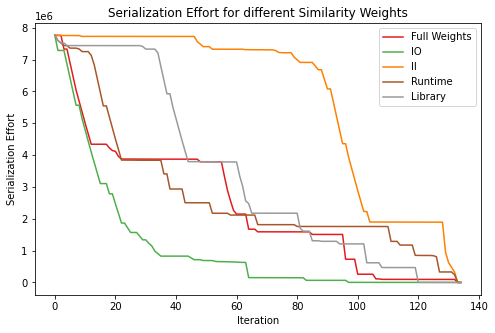

In [920]:
effort_plot("Serialization", dfFull, dfIO, dfII, dfR, dfL, xlim=None, ylim=None)

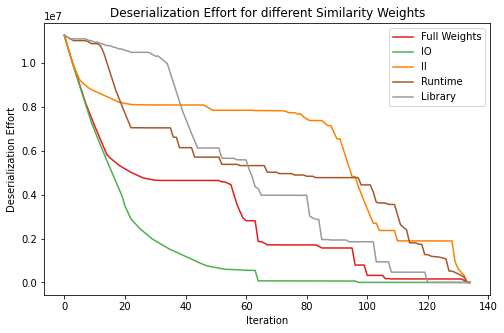

In [921]:
effort_plot("Deserialization", dfFull, dfIO, dfII, dfR, dfL, xlim=None, ylim=None)

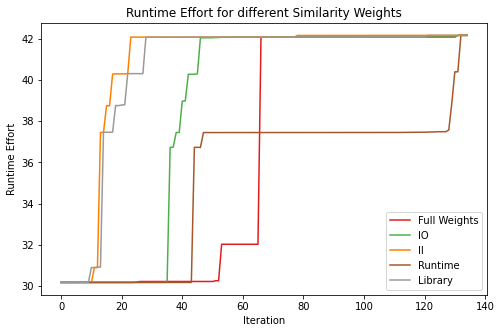

In [922]:
effort_plot("Runtime", dfFull, dfIO, dfII, dfR, dfL, xlim=None, ylim=None)

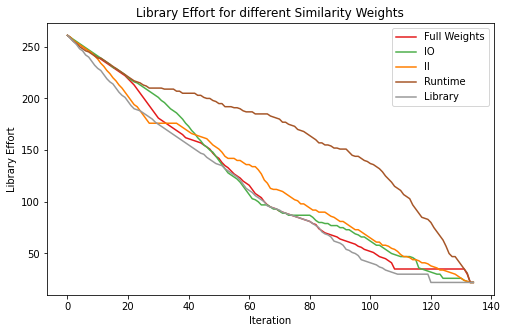

In [923]:
effort_plot("Library", dfFull, dfIO, dfII, dfR, dfL, xlim=None, ylim=None)

<div class="alert alert-block alert-success" style="margin-top: 20px">

## 5.3 Plotting WEV for Different Static Metrics
    
</div>

In [927]:
def plot_lines(name, df, iteration):
    """
    Compares WEV for different static criteria.
    """
    for n in ["SER", "DESER", "RUN", "LIB"]:
        orName = "Original "+n
        sName = "Static "+n
        newDf = df[[orName, sName]]
    
        p = newDf.plot(kind="line", rot=0, figsize=(6, 4), colormap="Set1")

        plt.title("Effort for different Static Metrics")
        plt.xlabel("Iteration")
        plt.ylabel("{} Effort".format(n))
        plt.savefig("results/plots/{}_{}_Line.png".format(name,n), dpi=300)
        plt.show()

In [928]:
def static_plot(name, dfFull, dfStatic, iteration):
    """
    Create line plot for certain static metrics.
    Potential effort values: "Serialization", "Deserialization",
        "Runtime", "Library".
    """
    Full1 = dfFull["Serialization"].rename("Original SER")
    Full2 = dfFull["Deserialization"].rename("Original DESER")
    Full3 = dfFull["Runtime"].rename("Original RUN")
    Full4 = dfFull["Library"].rename("Original LIB")
    
    Static1 = dfStatic["Serialization"].rename("Static SER")
    Static2 = dfStatic["Deserialization"].rename("Static DESER")
    Static3 = dfStatic["Runtime"].rename("Static RUN")
    Static4 = dfStatic["Library"].rename("Static LIB")
    
    lines = [Full1, Full2, Full3, Full4, Static1, Static2, Static3, Static4]
    df = pd.concat(lines, axis=1)
    
    plot_lines(name, df, iteration)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

In [929]:
timeframe = 5
lineframe = -1
datalim = -1
df5RUN, runLOCS, runIOs, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,1,1,1])

Running Test for weights [1, 1, 1, 1], LOCLim -1, RUNLim 5, and DATALim -1


No more sims
Modularization stopped. 


In [930]:
timeframe = -1
lineframe = 15
datalim = -1
df15LOC, locLOCS, locIOs, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,1,1,1])

Running Test for weights [1, 1, 1, 1], LOCLim 15, RUNLim -1, and DATALim -1


No more sims
Modularization stopped. 


In [931]:
timeframe = -1
lineframe = -1
datalim = 3
df3DATA, dataLOCS, dataIOs, g = analyze_modularization_iters(200, Graph, timeframe, lineframe, datalim, maxDatasize, maxRuntime, [1,1,1,1])

Running Test for weights [1, 1, 1, 1], LOCLim -1, RUNLim -1, and DATALim 3


No more sims
Modularization stopped. 


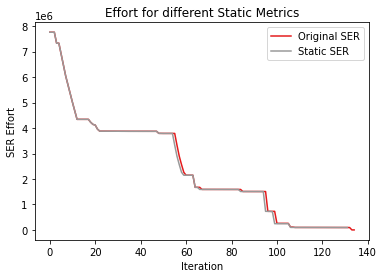

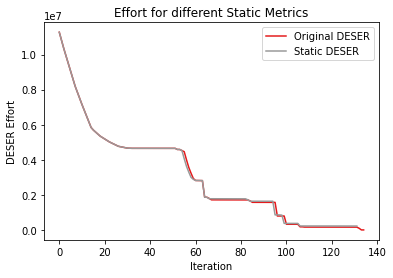

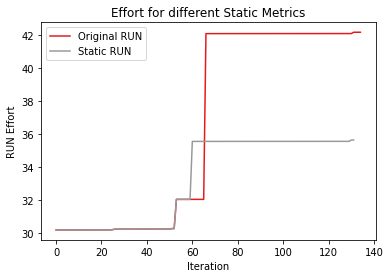

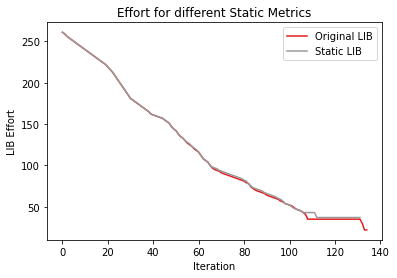

In [932]:
static_plot("5RUN", dfFull, df5RUN, 133)

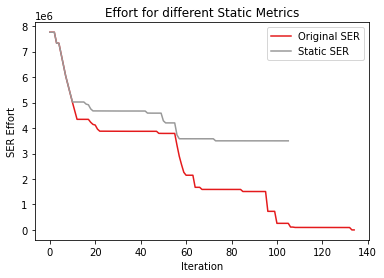

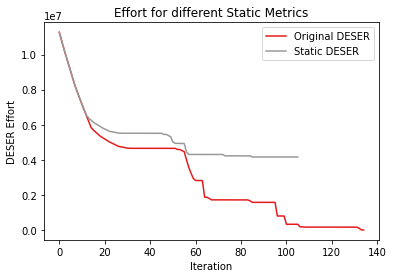

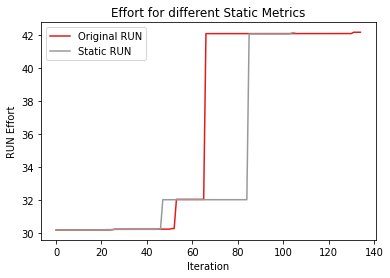

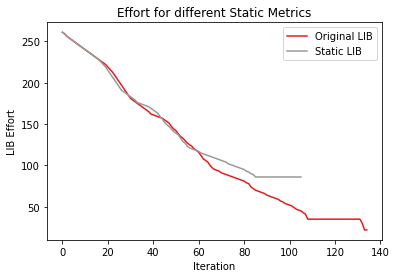

In [933]:
static_plot("15LOC", dfFull, df15LOC, 133)

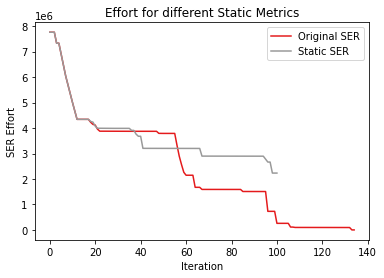

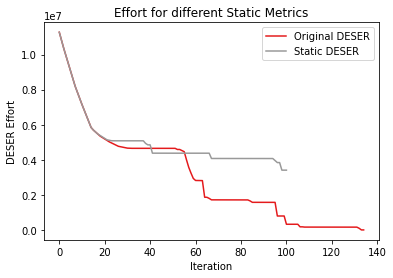

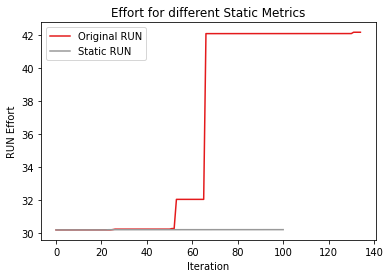

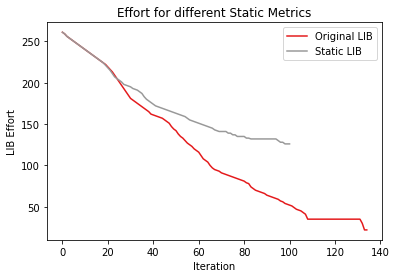

In [934]:
static_plot("3DATA", dfFull, df3DATA, 133)

In [935]:
print("Mean lines of code per node for lineframe = 15: ", locLOCS[100][2])
print("Mean lines of code per node for lineframe = unlimited: ", fullLOC[100][2])
print()
print("Mean Deviation of LOC for lineframe = 15: ", locLOCS[100][3])
print("Mean Deviation of LOC for lineframe = unlimited: ", fullLOC[100][3])

Mean lines of code per node for lineframe = 15:  11.794117647058824
Mean lines of code per node for lineframe = unlimited:  11.794117647058824

Mean Deviation of LOC for lineframe = 15:  3.795847750865052
Mean Deviation of LOC for lineframe = unlimited:  14.155709342560554


In [940]:
print("Max number of inputs per node for datalime = 3: {}\n and for datalim = unlimited: {}".format(dataIOs[100][0], fullData[100][0]))
print("Max number of outputs per node for datalime = 3: {}\n and for datalim = unlimited: {}".format(dataIOs[100][1], fullData[100][1]))
print()
print("Mean number of inputs for datalim = 3: {}\n and for datalim = unlimited: {}".format(dataIOs[100][2], fullData[100][2]))
print("Mean number of outputs for datalim = 3: {}\n and for datalim = unlimited: {}".format(dataIOs[100][3], fullData[100][3]))

Max number of inputs per node for datalime = 3: 6
 and for datalim = unlimited: 18
Max number of outputs per node for datalime = 3: 3
 and for datalim = unlimited: 10

Mean number of inputs for datalim = 3: 3.257142857142857
 and for datalim = unlimited: 2.3823529411764706
Mean number of outputs for datalim = 3: 1.8
 and for datalim = unlimited: 1.9411764705882353


<div class="alert alert-block alert-success" style="margin-top: 20px">

## 5.3 Comparing Clustering
    
</div>

### Statically cut dictionaries

In [941]:
def static_modularization(Graph, iters):
    """
    Create static clustering by creating |#nodes - iters| clusters of equal size.
    """
    dictionaries = extract_dictionaries(Graph)
    numNodes = len(Graph)-iters
    clustersize = int(len(Graph)/numNodes)
    if (clustersize < 1):
        print("Not enough original nodes, choose lower iters") 
        return list()
    
    # get nodes to merge
    nodesToMerge = list()
    resNodes = list()
    i=0
    while i in range(0, len(Graph)):
        resNodes.append(i)
        i += clustersize
    resNodes.append(len(Graph)-1)
    # build list of nodes that need to be merged
    iter = 0
    for j in range(0, len(resNodes)-1):
        res = resNodes[j]
        k = res + 1
        while k < resNodes[j+1]:
            nodesToMerge.append((res, k))
            k+= 1
            
    return nodesToMerge

In [942]:
def mod_graph_static(Graph, nodeIDs, staticNodes):
    """
    Creates modularized graph according to static clustering suggestion.
    """
    for pair in staticNodes:
        a = nodeIDs[pair[0]]
        b = nodeIDs[pair[1]]  
        
        nodeA = Graph.nodes[a]
        nodeB = Graph.nodes[b]
        
        needed_input = get_needed_inputs(Graph, a, b)
        needed_output = get_needed_outputs(Graph, a, b)
        node = merge_nodes_real(nodeA, nodeB, needed_input, needed_output)
        
        Graph = update_graph(Graph, a, b, node)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

#### Execution
   
</div>

In [943]:
staticNodes = static_modularization(Graph, maxIters+1)

In [944]:
modGraphStatic = Graph.copy()
mod_graph_static(modGraphStatic, nodeIDs, staticNodes)

In [945]:
staticDicts = extract_dictionaries(modGraphStatic)

### Efforts for static clustering (after maxIters +1 iterations)

In [946]:
staticSerEffort = get_serialization_effort(modGraphStatic)

In [947]:
staticDeserEffort = get_deserialization_effort(modGraphStatic)

In [948]:
staticRunEffort, path = get_runtime_effort(modGraphStatic)

In [949]:
staticLibEffort = get_library_effort(modGraphStatic)

### Efforts for topological clustering (after maxIters +1 iterations)

In [950]:
topSerEffort = get_serialization_effort(modGraphTopFull)

In [951]:
topDeserEffort = get_deserialization_effort(modGraphTopFull)

In [952]:
topRunEffort, path = get_runtime_effort(modGraphTopFull)

In [953]:
topLibEffort = get_library_effort(modGraphTopFull)

### Efforts for thorough clustering (after maxIters +1 iterations)

In [954]:
thoSerEffort = get_serialization_effort(modGraphFull)

In [955]:
thoDeserEffort = get_deserialization_effort(modGraphFull)

In [956]:
thoRunEffort, path = get_runtime_effort(modGraphFull)

In [957]:
thoLibEffort = get_library_effort(modGraphFull)

***
## Results

In [958]:
import pandas as pd

print("Topological Clustering executed in: ", topTime)
print("Thorough Clustering executed in: ", thoroughTime)

effortDict = {"Serialization":[staticSerEffort, topSerEffort, thoSerEffort],
             "Deserialization":[staticDeserEffort, topDeserEffort, thoDeserEffort],
             "Runtime":[staticRunEffort, topRunEffort, thoRunEffort],
             "Library":[staticLibEffort, topLibEffort, thoLibEffort]}

df = pd.DataFrame(effortDict, index = ['Static', 'Topological', 'Thorough'])
display(df)

Topological Clustering executed in:  0.1618506908416748
Thorough Clustering executed in:  103.40613317489624


Serialization  Deserialization    Runtime  Library
Static             3954385          4856522  42.158755      131
Topological        2964264          3516333  31.961624       79
Thorough            258233           322777  42.080246       51